In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns 

matplotlib.rcParams['pdf.fonttype'] = 42

### Load
df = pd.read_csv("/home/mouren/Data/valid_exp/summary_count_exonhancers_bilan.tsv", sep="\t", header=0)
df = df[~df['Log2FC'].str.contains('#', na=False)] # Remove rows with no log2FC values

df["Log2FC"] = df["Log2FC"].str.replace(',', '.')
df["Input_STD"] = df["Input_STD"].str.replace(',', '.')

df["Log2FC"] = pd.to_numeric(df["Log2FC"])
df["count_sequence_AVO4Exonhmaxi4"] = pd.to_numeric(df["count_sequence_AVO4Exonhmaxi4"])
df["Input_STD"] = pd.to_numeric(df["Input_STD"])

df_no_snp = df[(df['count_sequence_AVO4Exonhmaxi4'] >= 500) & (df['Input_STD'] <= 20) & (df['Category2'] == "EEK")]
filtered_df_snp = df[(df['count_sequence_AVO4Exonhmaxi4'] >= 500) & (df['Input_STD'] <= 20) & ((df['Category2'] == "EESNP") | (df['Category2'] == "EEMULTISNP"))]

## Dic to get matching single for multi
dic_multi_eesnp = {}
list_id_pairing_with_someone = []
with open("/home/mouren/Data/valid_exp/stat/seq_EESNP_MULTISEQ_id.tsv") as file:
    for line in file:      
        list_id_pairing_with_someone.append(line.strip().split("\t")[0])
        list_id_pairing_with_someone.append(line.strip().split("\t")[1])
        if line.strip().split("\t")[1] not in dic_multi_eesnp:
            dic_multi_eesnp[line.strip().split("\t")[1]] = [line.strip().split("\t")[0]]
        else:
            dic_multi_eesnp[line.strip().split("\t")[1]].append(line.strip().split("\t")[0])

In [8]:
#### Get significante single and multi vs ref, and their fc

## Dic ID SNP TO REF
dic_snp_ref_id = {}
with open("/home/mouren/Data/valid_exp/stat/seq_snp_ref_id.tsv") as file:
    for line in file:      
        dic_snp_ref_id[line.strip().split("\t")[0]] = line.strip().split("\t")[1]

nb_single_down = 0
nb_single_up = 0
nb_multi_down = 0
nb_multi_up = 0

### Iterate on sig sequences snps  vs ref 
sig_id_present = []
content_sig = [["ID","Log2FC_diff°","Type","Color"]]
with open("/home/mouren/Data/valid_exp/stat/all_starr_snp_vs_ref_FDR_wald.tsv") as file:
    for line in file:    
        if float(line.strip().split()[1])<0.05 :
            key = line.strip().split("\t")[0]

            if key not in list_id_pairing_with_someone: #if the sequence with snp dont have a single or multi mutated matching seq, we pass it 
                continue

            if "EESNP" in key:
                type = "Single"
                color = "green"
            else:
                type = "Multi"
                color = "purple"

            matching_no_snp = df_no_snp.loc[df_no_snp['ID'] == dic_snp_ref_id[key]]
            matching_wth_snp = filtered_df_snp.loc[filtered_df_snp['ID'] == key]

            fc_diff_snp_vs_ref = matching_wth_snp["Log2FC"].iloc[0] - matching_no_snp["Log2FC"].iloc[0]

            if type == "Single":
                if fc_diff_snp_vs_ref <0:
                    nb_single_down+=1
                else:
                    nb_single_up+=1
            else:
                if fc_diff_snp_vs_ref <0:
                    nb_multi_down+=1
                else:
                    nb_multi_up+=1

            sig_id_present.append(key)
            content_sig.append([key,fc_diff_snp_vs_ref,type,color])

header = content_sig[0]
rows = content_sig[1:]
df_content_sig = pd.DataFrame(rows, columns=header)

### Iterate on sig sequences to find matching 
## Dic to get matching multi for single
dic_eesnp_multi = {}
with open("/home/mouren/Data/valid_exp/stat/seq_EESNP_MULTISEQ_id.tsv") as file:
    for line in file:      
        dic_eesnp_multi[line.strip().split("\t")[0]] = line.strip().split("\t")[1]

no_sig_id_present = []
content_no_sig = [["ID","Log2FC_diff°","Type","Color"]]
for index, row in df_content_sig.iterrows():
    key = row["ID"]
    if "MULTISNP" in key :
        if key in dic_multi_eesnp:   
            for seq_single_snp in dic_multi_eesnp[key]: #iterate on each single snp sequence of that multi snp seq 
                #if that matching sequence was already added 
                if seq_single_snp in sig_id_present or seq_single_snp in no_sig_id_present:
                    continue
                        
                matching_no_snp = df_no_snp.loc[df_no_snp['ID'] == dic_snp_ref_id[seq_single_snp]]
                matching_wth_snp = filtered_df_snp.loc[filtered_df_snp['ID'] == seq_single_snp]

                fc_diff_snp_vs_ref = matching_wth_snp["Log2FC"].iloc[0] - matching_no_snp["Log2FC"].iloc[0]
                no_sig_id_present.append(seq_single_snp)
                content_no_sig.append([seq_single_snp,fc_diff_snp_vs_ref,"Single","lightgrey"])

    else: #single snp sig compared to ref
        if key in dic_eesnp_multi:  #single snp has matching multipple 
            #if that matching sequence was already added 
            if dic_eesnp_multi[key] in sig_id_present or dic_eesnp_multi[key] in no_sig_id_present:
                    continue
            
            matching_multi_snp = filtered_df_snp.loc[filtered_df_snp['ID'] == dic_eesnp_multi[key]]
            matching_no_snp = df_no_snp.loc[df_no_snp['ID'] == dic_snp_ref_id[dic_eesnp_multi[key]]]

            fc_diff_snp_vs_ref = matching_multi_snp["Log2FC"].iloc[0] - matching_no_snp["Log2FC"].iloc[0]
            no_sig_id_present.append(dic_eesnp_multi[key])
            content_no_sig.append([dic_eesnp_multi[key],fc_diff_snp_vs_ref,"Multi","lightgrey"])

header = content_no_sig[0]
rows = content_no_sig[1:]
df_content_no_sig = pd.DataFrame(rows, columns=header)  

#Make list of sig and not pairs
list_sig_single_multi_diff = []
list_no_sig_single_multi_diff = []
with open("/home/mouren/Data/valid_exp/stat/all_starr_EESNP_vs_MULTI_FDR_wald.tsv") as file:
    for line in file: 
        if line.strip().split()[0] in sig_id_present or line.strip().split()[0] in no_sig_id_present:
            pair = (line.strip().split()[0],dic_eesnp_multi[line.strip().split()[0]])
            if float(line.strip().split()[1])<0.05 :    
                list_sig_single_multi_diff.append(pair)
            else:
                list_no_sig_single_multi_diff.append(pair)

In [20]:
#nb sig association
nb_sig_asso_up = 0
nb_sig_asso_down = 0
nb_sig_asso_up_from_non_sig_single = 0
nb_sig_asso_down_from_non_sig_single = 0
nb_sig_asso_up_to_non_sig_multi = 0
nb_sig_asso_down_to_non_sig_multi = 0

for i,j in list_sig_single_multi_diff:
    #if both seq are sig
    if i in sig_id_present and j in sig_id_present:
        #if fc singleVSref higher than fc MultiVSref 
        if df_content_sig.loc[df_content_sig['ID'] == i]["Log2FC_diff°"].iloc[0] > df_content_sig.loc[df_content_sig['ID'] == j]["Log2FC_diff°"].iloc[0]: 
            nb_sig_asso_down +=1
        else:
            nb_sig_asso_up += 1
    
    #single not sig but multi yes 
    elif i not in sig_id_present and j in sig_id_present:
        if df_content_no_sig.loc[df_content_no_sig['ID'] == i]["Log2FC_diff°"].iloc[0] > df_content_sig.loc[df_content_sig['ID'] == j]["Log2FC_diff°"].iloc[0]: 
            nb_sig_asso_down +=1
            nb_sig_asso_down_from_non_sig_single +=1
        else:
            nb_sig_asso_up += 1
            nb_sig_asso_up_from_non_sig_single +=1

    #single sig but multi no 
    elif i in sig_id_present and j not in sig_id_present:
        if df_content_sig.loc[df_content_sig['ID'] == i]["Log2FC_diff°"].iloc[0] > df_content_no_sig.loc[df_content_no_sig['ID'] == j]["Log2FC_diff°"].iloc[0]: 
            nb_sig_asso_down +=1
            nb_sig_asso_down_to_non_sig_multi +=1
        else:
            nb_sig_asso_up += 1
            nb_sig_asso_up_to_non_sig_multi +=1



/tmp/ipykernel_305007/3371273814.py:71: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


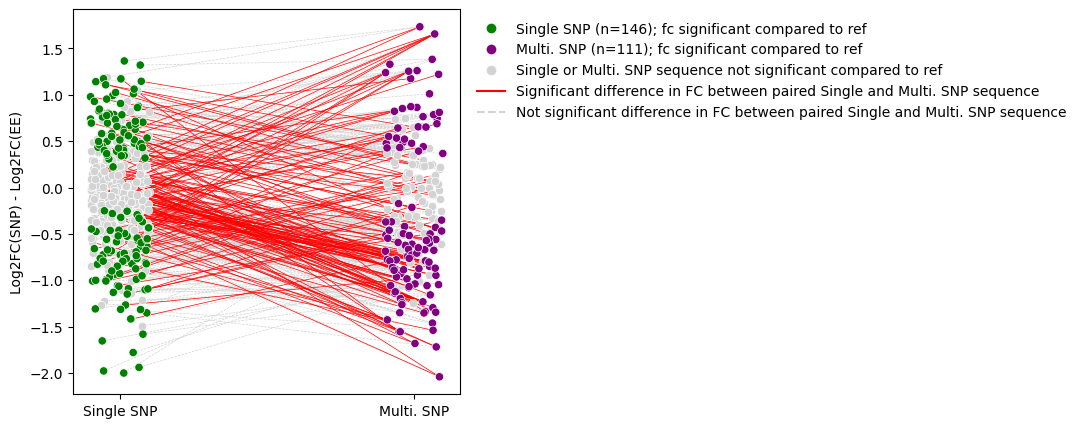

In [21]:
### PLOT
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define category mapping explicitly
category_map = {"Single": 0, "Multi": 1}

# Apply jitter manually
jitter_strength = 0.1  # Adjust for desired spread
df_content_no_sig["x_jitter"] = df_content_no_sig["Type"].map(category_map) + np.random.uniform(-jitter_strength, jitter_strength, size=len(df_content_no_sig))
df_content_sig["x_jitter"] = df_content_sig["Type"].map(category_map) + np.random.uniform(-jitter_strength, jitter_strength, size=len(df_content_sig))

plt.figure(figsize=(5, 5))

# Connect points only between different categories
# Store points in dictionary
point_dict = {row["ID"]: (row["x_jitter"], row["Log2FC_diff°"]) for _, row in pd.concat([df_content_no_sig, df_content_sig]).iterrows()}

for id1, id2 in list_no_sig_single_multi_diff:
    if id1 in point_dict and id2 in point_dict:
        x1, y1 = point_dict[id1]
        x2, y2 = point_dict[id2]
        
        # Ensure connections only between different categories
        if ((x1 < 0.5 and x2 > 0.5) or (x1 > 0.5 and x2 < 0.5)):  # Middle point ensures different categories
            plt.plot([x1, x2], [y1, y2], color="lightgrey", linestyle="--", linewidth=0.5)
        else:
            print(f"Warning: Incorrect connection attempted between {id1} (x={x1}) and {id2} (x={x2})")

for id1, id2 in list_sig_single_multi_diff:
    if id1 in point_dict and id2 in point_dict:
        x1, y1 = point_dict[id1]
        x2, y2 = point_dict[id2]
        
        # Ensure connections only between different categories
        if ((x1 < 0.5 and x2 > 0.5) or (x1 > 0.5 and x2 < 0.5)):  # Middle point ensures different categories
            plt.plot([x1, x2], [y1, y2], color="red", linestyle="-", linewidth=0.5)
        else:
            print(f"Warning: Incorrect connection attempted between {id1} (x={x1}) and {id2} (x={x2})")

# Scatter plots with manual jitter
ax_no = sns.scatterplot(
    x="x_jitter", y="Log2FC_diff°", data=df_content_no_sig, color="lightgrey",zorder=10 #alpha=1
)
ax_sig = sns.scatterplot(
    x="x_jitter", y="Log2FC_diff°", data=df_content_sig, hue="Type",zorder=15,
    palette=["green", "purple"],# alpha=1
)

plt.xticks([0, 1], ["Single SNP", "Multi. SNP"])  # Ensure correct x-ticks

plt.xlabel(None)
plt.ylabel("Log2FC(SNP) - Log2FC(EE)")


## Legend
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

legend_entry = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=8, label='Single SNP (n=146); fc significant compared to ref'),
                Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=8, label='Multi. SNP (n=111); fc significant compared to ref'),
                Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgrey', markersize=8, label='Single or Multi. SNP sequence not significant compared to ref'),
                Line2D([], [], color='red', linestyle='-', label="Significant difference in FC between paired Single and Multi. SNP sequence"),
                Line2D([], [], color='lightgrey', linestyle='--', label="Not significant difference in FC between paired Single and Multi. SNP sequence"),
                ]

plt.legend(handles=legend_entry, frameon=False, bbox_to_anchor=(1.01, 1))

plt.tight_layout()

plt.savefig("/home/mouren/Images/tls1/main_figures/fig4/diff_multi_single_snp_fig4e.pdf", format="pdf", bbox_inches="tight")
plt.savefig("/home/mouren/Images/tls1/main_figures/fig4/diff_multi_single_snp_fig4e.png", format="png", bbox_inches="tight")

plt.show()
